<a href="https://colab.research.google.com/github/saadqaqa-etu/nettoyer-les-donn-es-textuelles-prevenants-des-tweets-/blob/main/pfav2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Input, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Download NLTK stopwords
nltk.download('stopwords')

# Define preprocessing functions
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove mentions (@username) and hashtags (#)
    text = re.sub(r'@[^\s]+', '', text)
    text = re.sub(r'#', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Rejoin tokens into a single string
    text = ' '.join(tokens)

    return text

json_file_path = 'drive/MyDrive/train.json'
df = pd.read_json(json_file_path)

df['tweet'] = df['tweet'].astype(str)
df['tweet'] = df['tweet'].apply(preprocess_text)

# Define parameters for tokenization and padding
max_vocabulary = 4000
max_length = 50
embedding_size = 100

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_vocabulary)
tokenizer.fit_on_texts(df['tweet'])
sequences = tokenizer.texts_to_sequences(df['tweet'])
Data_T = pad_sequences(sequences, maxlen=max_length)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(Data_T, df.label, test_size=0.2501, random_state=42)

glove_file = 'drive/MyDrive/glove.twitter.27B.100d.txt'  # Replace with the path to your GloVe file
word_vectors = {}
with open(glove_file, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        word_vectors[word] = vector

vocabulary_size = max_vocabulary
embedding_dim = 100

embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocabulary_size:
        embedding_vector = word_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

# Hyperparameter Tuning
learning_rate = 0.001  #  the learning rate
batch_size = 64  #  batch size
epochs = 50  #  the number of epochs

#  deep learning model
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)


#  Conv1D layer
conv1d_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)

from keras.layers import Bidirectional, GRU, LSTM



#  BiGRU and LSTM layers
bigru_layer1 = Bidirectional(GRU(100, return_sequences=True))(conv1d_layer)
dropout1 = Dropout(0.5)(bigru_layer1)

lstm_layer1 = LSTM(100, return_sequences=True)(dropout1)
dropout2 = Dropout(0.5)(lstm_layer1)

bigru_layer2 = Bidirectional(GRU(100, return_sequences=True))(dropout2)
dropout3 = Dropout(0.5)(bigru_layer2)

lstm_layer2 = LSTM(100, return_sequences=True)(dropout3)
dropout4 = Dropout(0.5)(lstm_layer2)





#  GlobalMaxPooling1D layer
maxpooling_layer = GlobalMaxPooling1D()(dropout2)

# Dense layer for classification
output_layer = Dense(1, activation='sigmoid')(maxpooling_layer)

# Compile the model with adjusted learning rate
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Implement cross-validation
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, val_index in kf.split(Data_T, df.label):
    x_train, x_val = Data_T[train_index], Data_T[val_index]
    y_train, y_val = df.label[train_index], df.label[val_index]

    # Train the model
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=1)

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f'Test loss: {loss}, Test accuracy: {accuracy}')

    # Predict on the test set
    y_pred = (model.predict(x_test) > 0.5).astype(int)

    # Calculate and display classification report
    classification_rep = classification_report(y_test, y_pred)
    print(classification_rep)


Epoch 1/50
87/87 [==============================] - 18s 139ms/step - loss: 0.6590 - accuracy: 0.6138 - val_loss: 0.6477 - val_accuracy: 0.6424
Epoch 2/50
87/87 [==============================] - 11s 125ms/step - loss: 0.6257 - accuracy: 0.6513 - val_loss: 0.6349 - val_accuracy: 0.6304
Epoch 3/50
87/87 [==============================] - 10s 117ms/step - loss: 0.5978 - accuracy: 0.6682 - val_loss: 0.6381 - val_accuracy: 0.6489
Epoch 4/50
87/87 [==============================] - 9s 109ms/step - loss: 0.5833 - accuracy: 0.6910 - val_loss: 0.6285 - val_accuracy: 0.6395
Epoch 5/50
87/87 [==============================] - 9s 105ms/step - loss: 0.5647 - accuracy: 0.7012 - val_loss: 0.6250 - val_accuracy: 0.6598
Epoch 6/50
87/87 [==============================] - 9s 103ms/step - loss: 0.5231 - accuracy: 0.7403 - val_loss: 0.6322 - val_accuracy: 0.6460
Epoch 7/50
87/87 [==============================] - 9s 104ms/step - loss: 0.4526 - accuracy: 0.7901 - val_loss: 0.6342 - val_accuracy: 0.6551
Epo

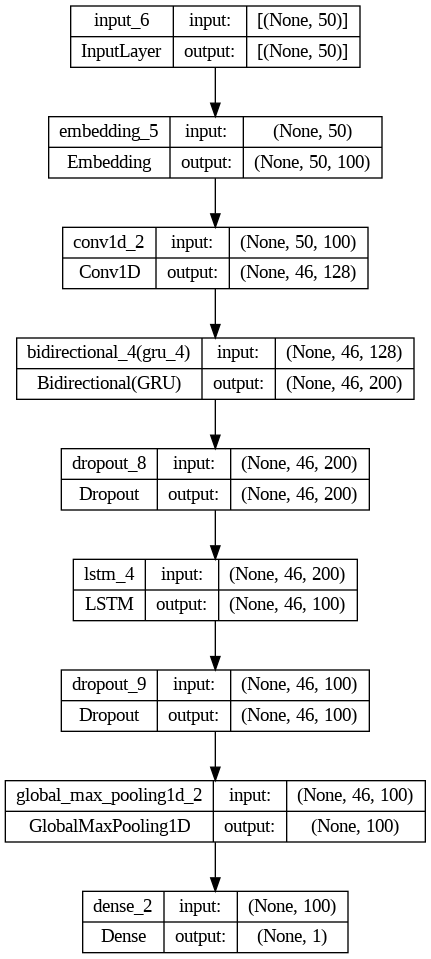

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_visualization.png', show_shapes=True)


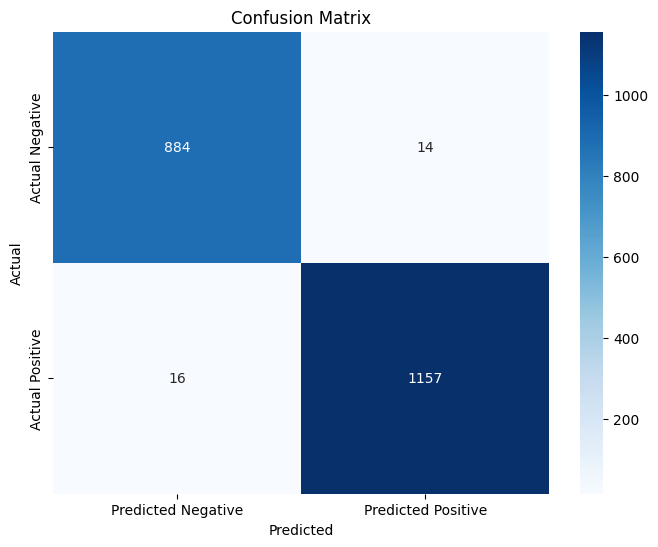

False Positive Rate: 0.015590200445434299
Specificity (True Negative Rate): 0.9863597612958227
False Negative Rate: 0.013640238704177323


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("False Positive Rate:", false_positive_rate)

specificity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("Specificity (True Negative Rate):", specificity)

false_negative_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("False Negative Rate:", false_negative_rate)

0.9880444064901793 0.9863597612958227 0.9872013651877133


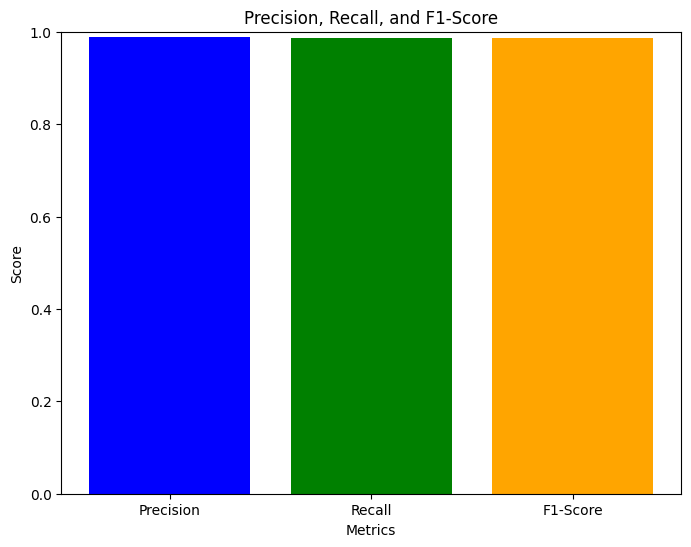

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt



precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)
plt.title('Precision, Recall, and F1-Score')
print(precision, recall, f1)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.show()


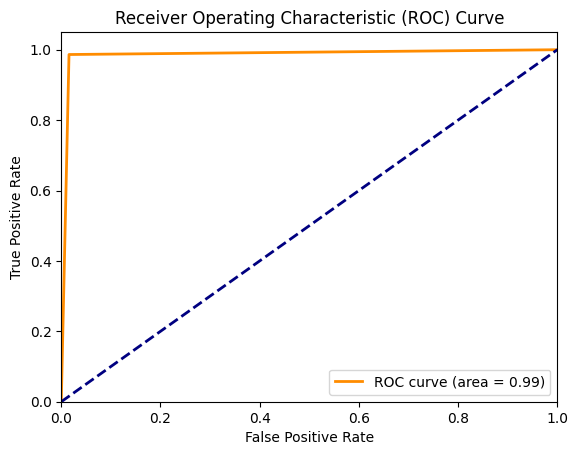

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

